<a href="https://colab.research.google.com/github/GabrielWu2004/Numerai/blob/main/Numerai_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data

In [1]:
pip install numerapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn

In [3]:
from numerapi import NumerAPI
napi = NumerAPI()
napi.download_dataset("v4/train.parquet", "train.parquet")
napi.download_dataset("v4/validation.parquet", "validation.parquet")

train.parquet: 1.15GB [00:21, 53.3MB/s]                            
validation.parquet: 1.12GB [00:23, 47.2MB/s]                            


In [4]:
training_data = pd.read_parquet('train.parquet')

In [5]:
print(training_data.shape)
print(training_data.head())

(2420521, 1222)
                   era data_type  feature_honoured_observational_balaamite  \
id                                                                           
n003bba8a98662e4  0001     train                                       1.0   
n003bee128c2fcfc  0001     train                                       0.5   
n0048ac83aff7194  0001     train                                       0.5   
n00691bec80d3e02  0001     train                                       1.0   
n00b8720a2fdc4f2  0001     train                                       1.0   

                  feature_polaroid_vadose_quinze  \
id                                                 
n003bba8a98662e4                            0.50   
n003bee128c2fcfc                            1.00   
n0048ac83aff7194                            0.25   
n00691bec80d3e02                            0.50   
n00b8720a2fdc4f2                            0.75   

                  feature_untidy_withdrawn_bargeman  \
id               

In [7]:
features = [c for c in training_data if c.startswith("feature")]
targets = [c for c in training_data if c.startswith("target")]
training_data["erano"] = training_data.era.astype(int)

In [8]:
print(features[:5])
print(targets[:5])
print(training_data["erano"][:5])

['feature_honoured_observational_balaamite', 'feature_polaroid_vadose_quinze', 'feature_untidy_withdrawn_bargeman', 'feature_genuine_kyphotic_trehala', 'feature_unenthralled_sportful_schoolhouse']
['target', 'target_nomi_v4_20', 'target_nomi_v4_60', 'target_tyler_v4_20', 'target_tyler_v4_60']
id
n003bba8a98662e4    1
n003bee128c2fcfc    1
n0048ac83aff7194    1
n00691bec80d3e02    1
n00b8720a2fdc4f2    1
Name: erano, dtype: int64


## Reduce Features ##

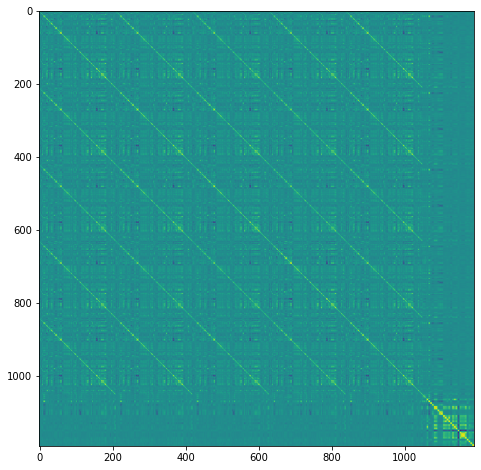

In [29]:
plt.figure(figsize = (8, 8))
plt.imshow(training_data[training_data.era == '0001'][features].corr())

In [27]:
df_A = training_data[training_data.era == '0001'][features[0]]

res = []
for i in range(len(features)):
  df_B = training_data[training_data.era == '0001'][features[i]]
  if df_A.corr(df_B) > 0.5:
    print((i, df_A.corr(df_B)))

# grouping:
# 0 - 209
# 210 - 419
# 420 - 629
# 630 - 839
# 840 - (presumably) 1049
# 1050 - (end) 1222

(0, 1.0)
(25, 0.7639826422372228)
(26, 0.6820154291224686)
(196, 0.5270009643201542)
(210, 0.9047733847637416)
(235, 0.7099807135969142)
(236, 0.6248794599807136)
(420, 0.8543876567020249)
(445, 0.6728543876567019)
(446, 0.5802796528447444)
(630, 0.8758437801350047)
(655, 0.8042430086788813)
(656, 0.6552555448408871)
(826, 0.524831243972999)
(840, 0.944069431051109)
(865, 0.7418032786885245)
(866, 0.6499517839922854)
(1036, 0.5016875602700096)


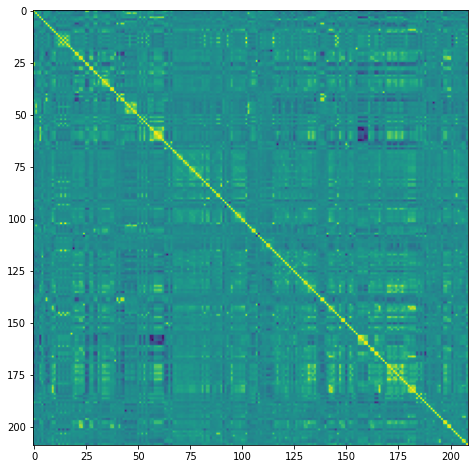

In [28]:
plt.figure(figsize = (8, 8))
plt.imshow(training_data[training_data.era == '0001'][features[:209]].corr())

## Reduce Eras ##

In [42]:
eras = training_data.erano
last_era = eras[eras.shape[0] - 1]
sub_era_1 = eras.isin(np.arange(1, last_era, 4))
sub_era_2 = eras.isin(np.arange(2, last_era, 4))
sub_era_3 = eras.isin(np.arange(3, last_era, 4))
sub_era_4 = eras.isin(np.arange(4, last_era, 4))

id
n003bba8a98662e4      1
n003bee128c2fcfc      1
n0048ac83aff7194      1
n00691bec80d3e02      1
n00b8720a2fdc4f2      1
                   ... 
nffc2d5e4b79a7ae    573
nffc7d24176548a4    573
nffc9844c1c7a6a9    573
nffd79773f4109bb    573
nfff87b21e4db902    573
Name: erano, Length: 606176, dtype: int64

## Reduce Data Size & Prep for Training ##

In [65]:
reduced_features = features[0:209]

reduced_train1_X = training_data[sub_era_1][reduced_features]
reduced_train1_y = training_data[sub_era_1]['target']
reduced_training_data_1 = pd.concat([reduced_train1_X, reduced_train1_y], axis = 'columns')

print(reduced_train1_X.shape)
print(reduced_train1_y.shape)
print(reduced_training_data_1.shape)

(606176, 209)
(606176,)
(606176, 210)


## Training ##

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [66]:
X_train, X_val, y_train, y_val = train_test_split(reduced_train1_X, reduced_train1_y, test_size = 0.2, random_state = 1)

In [75]:
xgb_model = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, tree_method = 'gpu_hist', gpu_id = 0)
xgb_model.fit(X_train, y_train, 
              early_stopping_rounds=5,
              eval_set = [(X_val, y_val)])

[17:20:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.22383
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.223821
[2]	validation_0-rmse:0.223811
[3]	validation_0-rmse:0.223803
[4]	validation_0-rmse:0.223794
[5]	validation_0-rmse:0.223786
[6]	validation_0-rmse:0.223778
[7]	validation_0-rmse:0.223773
[8]	validation_0-rmse:0.223769
[9]	validation_0-rmse:0.223763
[10]	validation_0-rmse:0.223759
[11]	validation_0-rmse:0.223753
[12]	validation_0-rmse:0.223748
[13]	validation_0-rmse:0.223743
[14]	validation_0-rmse:0.22374
[15]	validation_0-rmse:0.223735
[16]	validation_0-rmse:0.223731
[17]	validation_0-rmse:0.223727
[18]	validation_0-rmse:0.223722
[19]	validation_0-rmse:0.223719
[20]	validation_0-rmse:0.223716
[21]	validation_0-rmse:0.223714
[22]	validation_0-rmse:0.223711
[23]	validation_0-rmse:0.223707
[24]	validation_0-rmse:0.223704
[25]	validation_0-rms

XGBRegressor(gpu_id=0, learning_rate=0.05, n_estimators=1000,
             tree_method='gpu_hist')

In [76]:
xgb_model.score(X_val, y_val) # R^2

0.0017867992669617916